In [1]:
"""
main_00_iss.py
Satellite ground track plotting.
Demonstration of satellite ground track plotting. 
Reads in the position vectors in the Earth Centered Inertial or the Earth Centered Earth Fixed Frame, 
converts these to latitude and longitude and plots the location on an equirectangular-projected map.
Author: Ashiv Dhondea, RRSG, UCT.
Date: 05 December 2016
"""

#Cite:
#https://github.com/AshivDhondea/Satellite_Ground_Track_Plotting_Python

 

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
from matplotlib import colors
import matplotlib.patches as patches
import matplotlib as mpl
import pandas as pd

import datetime as dt
import pytz
import aniso8601

# The sgp4 computes the position and velocity of an earth-orbiting satellite, 
# given the satellite’s TLE orbital elements from a source like Celestrak.
#
# The wgs72 model seems to be the most commonly used in the satellite tracking community, 
# and is probably the model behind most TLE elements that are available for download.
from sgp4.earth_gravity import wgs72
from sgp4.io import twoline2rv

# The twoline2rv() function returns a Satellite object whose attributes carry the data loaded from the TLE entry:
    # Unique satellite number, as given in the TLE file.
    # The epoch of the element set, expressed three ways: 
        # as the integer year plus the floating point number of days into the year: satellite.epochyr + satellite.epochdays
        # as a floating-point Julian date:  satellite.jdsatepoch
        # and as Python datetime object: satellite.epoch
    #

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [2]:
"""
AstroFunctions.py

Astrodynamics Functions 

(Only a few functions from my original AstroFunctions.py are included here. )

Description:
Various Python functions useful for astrodynamics applications.
Most of these functions are based on Fundamentals of Astrodynamics, Vallado. 4th ed.

Author: Ashiv Dhondea, RRSG, UCT.
Date: 05 December 2016
"""
# ------------------------------------------------------------------------------------------ #
import numpy as np
import math
# ------------------------------------------------------------------------------------------ #

# Input a number of seconds and return number of : hours, minutes, seconds
def fnSeconds_To_Hours(time_period):
    num_hrs = int(time_period/(60.*60.));
    time_period =time_period - num_hrs*60.*60.;
    num_mins = int(time_period/60.);
    num_secs = time_period - num_mins*60.;
    return num_hrs,num_mins,num_secs # edit: 1/12/16: float division and multiplication

# This will be used to convert the TLE_epoch for each satellit to GMST
# datetime.datetime(2019, 1, 2, 12, 40, tzinfo=<UTC>)  to  5.094029323402314
def fn_Convert_Datetime_to_GMST(datetime_object):
    obj = datetime_object;
    julianday =  fnJulianDate(obj.year,obj.month,obj.day,obj.hour,obj.minute,obj.second);
    theta_GMST =  fn_Calculate_GMST(julianday);
    return theta_GMST # validated with example 3-5 in vallado.

# We will pass the theta_GMST from fn_Convert_Datetime_to_GMST() to this function 
# to make sure that our time is always from 0 to 2 pi.
# This ensures that 

def fnZeroTo2Pi(rotangle):
    """
    Wraps angle to fit in [0,2pi).
    Works in [rad] not [deg]
    Date: 7 October 2016
    """
    wrappedangle = rotangle % (2*math.pi);
    return wrappedangle
    
def fnECItoECEF(ECI,theta):
    ECEF = np.zeros([3],dtype=np.float64);
    # Rotating the ECI vector into the ECEF frame via the GST angle about the Z-axis
    ECEF = np.dot(fnRotate3(theta),ECI);
    return ECEF

# Calculate the Julian Date from the year, month, day, hour, minute, second.
# This will be used to convert datetime to GMST in fn_Convert_Datetime_to_GMST()
def fnJulianDate(yr, mo, d, h, m, s):
    """
    Implements Algo 14 in Vallado book: JulianDate
    Date: 05 October 2016
    """
    JD = 367.0*yr - int((7*(yr+ int((mo+9)/12)))/4.0) + int((275.0*mo)/9.0) + d+ 1721013.5 + ((((s/60.0)+m)/60+h)/24.0);
    return JD # validated with example 3-4 in vallado.

# Viewed from the same location, a star seen at one position in the sky 
# will be seen at the same position on another night at the same sidereal time. 
    # https://en.wikipedia.org/wiki/Sidereal_time
def fn_Calculate_GMST(JD):
    """
    Calculates the Greenwich Mean Sidereal Time according to eqn 3-47 on page 188 in Vallado.
    Date: 05 October 2016
    Edit: 06 October 2016: CAUTION: theta_GMST is output in [degrees] rather than in [radians], 
    unlike most of the angles in this file.
    """
    T_UT1 = (JD - 2451545.0)/36525.0
    theta_GMST = 67310.54841 + (876600.0*60*60 + 8640184.812866)*T_UT1 + 0.093104 * T_UT1**2 - 6.2e-6 * T_UT1**3;
    
    while theta_GMST > 86400.0:
        theta_GMST = theta_GMST - 86400;

    theta_GMST = theta_GMST/240.0;
    theta_GMST = theta_GMST - 360; # in [deg] not [rad] !!!!!!!!!!!!!!!!!!!!!!!!!!!
    return theta_GMST # validated with example 3-5 in vallado.

def fnRotate3(alpha_rad):
    T = np.array([[ math.cos(alpha_rad),math.sin(alpha_rad),0], 
                  [-math.sin(alpha_rad),math.cos(alpha_rad),0],
                  [                 0,                0,1]],dtype=np.float64);
    return T # Validated against Vallado's example 2-3. 20/06/16

def fnCarts_to_LatLon(R):
    """
    function which converts ECEF position vectors to latitude and longitude
    Based on rvtolatlong.m in Richard Rieber's orbital library on mathwork.com
    
    Note that this is only suitable for groundtrack visualization, not rigorous 
    calculations.
    Date: 18 September 2016
    """
    r_delta = np.linalg.norm(R[0:1]);
    sinA = R[1]/r_delta;
    cosA = R[0]/r_delta;

    Lon = math.atan2(sinA,cosA);

    if Lon < -math.pi:
        Lon = Lon + 2*math.pi;

    Lat = math.asin(R[2]/np.linalg.norm(R));
    return Lat,Lon


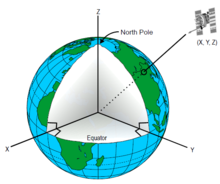

In [3]:
# Define the TLE order for the code below

#tle_line1 = '1 25544U 98067A   16298.89519381  .00003992  00000-0  67065-4 0  9991';
#tle_line2 = '2 25544  51.6430 131.0922 0007174 106.9148  32.6949 15.54320225 25163';

tle_line1 = '1 00001U 19067A   19001.00000000  .00003992  00000-0  67065-4 0  9991';
tle_line2 = '2 00001  90.0000 131.0922 0007174 106.9148  00.0000 15.54320225 25163';

tle_line3 = '1 00001U 19067A   19001.00000000  .00003992  00000-0  67065-4 0  9991';
tle_line4 = '2 00001  90.0000 131.0922 0007174 106.9148 120.0000 15.54320225 25163';

tle_line5 = '1 00001U 19067A   19001.00000000  .00003992  00000-0  67065-4 0  9991';
tle_line6 = '2 00001  90.0000 131.0922 0007174 106.9148 240.0000 15.54320225 25163';
# [?, Satellite Number, Inclination, RAAN, Eccentricity, Argument of Perigee, Mean Anomoly, ? ? ] 

line1 = (tle_line1);
line2 = (tle_line2);

line3 = (tle_line3);
line4 = (tle_line4);

line5 = (tle_line5);
line6 = (tle_line6);

# FOR IMFORMATION ON twoline2rv look below, 
# https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/submissions/54875/versions/3/previews/Geostationary%20Satellites%20Tracking%20-%20Tony%20C%20Huang/private/twoline2rv.m/index.html
satellite_obj  = twoline2rv(line1, line2, wgs72);
satellite_obj2 = twoline2rv(line3, line4, wgs72);
satellite_obj3 = twoline2rv(line5, line6, wgs72);

In [4]:
delta_t = .5; # step size
simulation_period = 95*60*2*4 ; # amount of time to run the simulation
                    # 95*60*2 is about 3 hours
###########################################
# Initialize a vector starting at 0, 
# with a step size of delta_t
# ending at delta_t past simulation_period, 
###########################################
timevec = np.arange(0,simulation_period+delta_t,delta_t,dtype=np.float64);
x_state = np.zeros([6,len(timevec)],dtype=np.float64); # [0:3] contain satpos as a 3x1 vector. [3:6] contain satvel as a 3x1 vector.
xecef = np.zeros([3,len(timevec)],dtype=np.float64);   # will contain x_state[0:3] converted to ECEF
lat = np.zeros([len(timevec)],dtype=np.float64);       # will contain xecef converted to latitude
lon = np.zeros([len(timevec)],dtype=np.float64);       # will contain xecef converted to longetude
# The function fnCarts_to_LatLon returns two numbers for each xecef value. lat and lon.

x_state2 = np.zeros([6,len(timevec)],dtype=np.float64);
xecef2 = np.zeros([3,len(timevec)],dtype=np.float64);
lat2 = np.zeros([len(timevec)],dtype=np.float64);
lon2 = np.zeros([len(timevec)],dtype=np.float64);

x_state3 = np.zeros([6,len(timevec)],dtype=np.float64);
xecef3 = np.zeros([3,len(timevec)],dtype=np.float64);
lat3 = np.zeros([len(timevec)],dtype=np.float64);
lon3 = np.zeros([len(timevec)],dtype=np.float64);

In [5]:
#fnCarts_to_LatLon(xecef[:,45000])


In [6]:
index = 0;
current_time = timevec[index];

# Take the epoch time and store it in dys,hrs,mins,secs
# this will be used in the propagate function to get the current satpos and satvel at time t
# dys
###########################
hrs,mins,secs = fnSeconds_To_Hours(current_time + (satellite_obj.epoch.hour*60*60) + (satellite_obj.epoch.minute*60)+ satellite_obj.epoch.second);
dys = satellite_obj.epoch.day + int(math.ceil(hrs/24));     
#
hrs2,mins2,secs2 = fnSeconds_To_Hours(current_time + (satellite_obj2.epoch.hour*60*60) + (satellite_obj2.epoch.minute*60)+ satellite_obj2.epoch.second);
dys2 = satellite_obj2.epoch.day + int(math.ceil(hrs/24));  
#
hrs3,mins3,secs3 = fnSeconds_To_Hours(current_time + (satellite_obj3.epoch.hour*60*60) + (satellite_obj3.epoch.minute*60)+ satellite_obj3.epoch.second);
dys3 = satellite_obj3.epoch.day + int(math.ceil(hrs/24)); 

###########################
if hrs >= 24:
    hrs = hrs - 24*int(math.ceil(hrs/24)) ;

# satpos is the 3x1 position vector from the center of the earth
# satvel is the 3x1 rate at which those three parameters are changing, expressed in kilometers per second.
# Propagate function returns these two vectors given dys,hrs,mins,secs
# satpos will converted to ecef, then to lat lon.
# satvel wll not be used anywhere.
satpos,satvel = satellite_obj.propagate(satellite_obj.epoch.year,satellite_obj.epoch.month,dys,hrs,mins,secs+(1e-6)*satellite_obj.epoch.microsecond);
#
satpos2,satvel2 = satellite_obj2.propagate(satellite_obj2.epoch.year,satellite_obj2.epoch.month,dys,hrs,mins,secs+(1e-6)*satellite_obj2.epoch.microsecond);
#
satpos3,satvel3 = satellite_obj3.propagate(satellite_obj3.epoch.year,satellite_obj3.epoch.month,dys,hrs,mins,secs+(1e-6)*satellite_obj3.epoch.microsecond);


# x_state[3:6] is not used anywhere. it contains satvel in 3x1
############################
x_state[0:3,index] = np.asarray(satpos); 
x_state[3:6,index] = np.asarray(satvel); 
#
x_state2[0:3,index] = np.asarray(satpos2);
x_state2[3:6,index] = np.asarray(satvel2);
#
x_state3[0:3,index] = np.asarray(satpos3);
x_state3[3:6,index] = np.asarray(satvel3);


############################
# the julian year,month,day,hr,sec is stored in tle_epoch_test as a datetime object
# use the fn_Convert_Datetime_to_GMST function to convert this julian year to a GMST angle.
# this GMST angle will be converted directly to an ECEF vector in R^3 stored in xecef below.
# this will be converted to lat long coordinates below.
tle_epoch_test = dt.datetime(year=satellite_obj.epoch.year,month=satellite_obj.epoch.month,day=int(dys),hour=int(hrs),minute=int(mins),second=int(secs),microsecond=0,tzinfo= pytz.utc);
theta_GMST =  math.radians(fn_Convert_Datetime_to_GMST(tle_epoch_test));        
#
tle_epoch_test2 = dt.datetime(year=satellite_obj2.epoch.year,month=satellite_obj2.epoch.month,day=int(dys),hour=int(hrs),minute=int(mins),second=int(secs),microsecond=0,tzinfo= pytz.utc);
theta_GMST2 =  math.radians(fn_Convert_Datetime_to_GMST(tle_epoch_test2));   
#
tle_epoch_test3 = dt.datetime(year=satellite_obj3.epoch.year,month=satellite_obj3.epoch.month,day=int(dys),hour=int(hrs),minute=int(mins),second=int(secs),microsecond=0,tzinfo= pytz.utc);
theta_GMST3 =  math.radians(fn_Convert_Datetime_to_GMST(tle_epoch_test3));  


## Rotate ECI position vector by GMST angle to get ECEF position
    # fnZeroTp2Pi converts the GMST ange from degrees to radians
    # xecef stores the position vector in R^3 as latitude and longetude.
############################
theta_GMST = fnZeroTo2Pi(theta_GMST);
xecef[:,index] = fnECItoECEF(x_state[0:3,index],theta_GMST);
lat[index],lon[index] = fnCarts_to_LatLon(xecef[:,index]);
#
theta_GMST2 = fnZeroTo2Pi(theta_GMST2);
xecef2[:,index] = fnECItoECEF(x_state2[0:3,index],theta_GMST2);
lat2[index],lon2[index] = fnCarts_to_LatLon(xecef2[:,index]);
#
theta_GMST3 = fnZeroTo2Pi(theta_GMST3);
xecef3[:,index] = fnECItoECEF(x_state3[0:3,index],theta_GMST2);
lat3[index],lon3[index] = fnCarts_to_LatLon(xecef3[:,index]);

# Update our lat lon for every time step.
############################
for index in range(1,len(timevec)):
    current_time = timevec[index];
    
    #########
    hrs,mins,secs = fnSeconds_To_Hours(current_time + (satellite_obj.epoch.hour*60*60) + (satellite_obj.epoch.minute*60)+ satellite_obj.epoch.second);
    dys = satellite_obj.epoch.day + int(math.ceil(hrs/24)); 
    #
    hrs2,mins2,secs2 = fnSeconds_To_Hours(current_time + (satellite_obj2.epoch.hour*60*60) + (satellite_obj2.epoch.minute*60)+ satellite_obj2.epoch.second);
    dys2 = satellite_obj2.epoch.day + int(math.ceil(hrs/24)); 
    #
    hrs3,mins3,secs3 = fnSeconds_To_Hours(current_time + (satellite_obj3.epoch.hour*60*60) + (satellite_obj3.epoch.minute*60)+ satellite_obj3.epoch.second);
    dys3 = satellite_obj3.epoch.day + int(math.ceil(hrs/24)); 
    #########
    
    if hrs >= 24:
        hrs = hrs - 24*int(math.ceil(hrs/24)) ;
    
    ##########
    satpos,satvel = satellite_obj.propagate(satellite_obj.epoch.year,satellite_obj.epoch.month,dys,hrs,mins,secs+(1e-6)*satellite_obj.epoch.microsecond);
    x_state[0:3,index] = np.asarray(satpos);
    x_state[3:6,index] = np.asarray(satvel);
    #
    satpos2,satvel2 = satellite_obj2.propagate(satellite_obj2.epoch.year,satellite_obj2.epoch.month,dys,hrs,mins,secs+(1e-6)*satellite_obj2.epoch.microsecond);
    x_state2[0:3,index] = np.asarray(satpos2);
    x_state2[3:6,index] = np.asarray(satvel2);
    #
    satpos3,satvel3 = satellite_obj3.propagate(satellite_obj3.epoch.year,satellite_obj3.epoch.month,dys,hrs,mins,secs+(1e-6)*satellite_obj3.epoch.microsecond);
    x_state3[0:3,index] = np.asarray(satpos3);
    x_state3[3:6,index] = np.asarray(satvel3);
    ##########
    
    ##########
    tle_epoch_test = dt.datetime(year=satellite_obj.epoch.year,month=satellite_obj.epoch.month,day=int(dys),hour=int(hrs),minute=int(mins),second=int(secs),microsecond=0,tzinfo= pytz.utc);
    theta_GMST =  math.radians(fn_Convert_Datetime_to_GMST(tle_epoch_test));
    #
    tle_epoch_test2 = dt.datetime(year=satellite_obj2.epoch.year,month=satellite_obj2.epoch.month,day=int(dys),hour=int(hrs),minute=int(mins),second=int(secs),microsecond=0,tzinfo= pytz.utc);
    theta_GMST2 =  math.radians(fn_Convert_Datetime_to_GMST(tle_epoch_test2));
    #
    tle_epoch_test3 = dt.datetime(year=satellite_obj3.epoch.year,month=satellite_obj3.epoch.month,day=int(dys),hour=int(hrs),minute=int(mins),second=int(secs),microsecond=0,tzinfo= pytz.utc);
    theta_GMST3 =  math.radians(fn_Convert_Datetime_to_GMST(tle_epoch_test3));
    ##########
    
    ## Rotate ECI position vector by GMST angle to get ECEF position
    ##########
    theta_GMST = fnZeroTo2Pi(theta_GMST);
    xecef[:,index] = fnECItoECEF(x_state[0:3,index],theta_GMST);
    lat[index],lon[index] = fnCarts_to_LatLon(xecef[:,index]);
    #
    theta_GMST2 = fnZeroTo2Pi(theta_GMST2);
    xecef2[:,index] = fnECItoECEF(x_state2[0:3,index],theta_GMST2);
    lat2[index],lon2[index] = fnCarts_to_LatLon(xecef2[:,index]);
    #
    theta_GMST3 = fnZeroTo2Pi(theta_GMST3);
    xecef3[:,index] = fnECItoECEF(x_state3[0:3,index],theta_GMST3);
    lat3[index],lon3[index] = fnCarts_to_LatLon(xecef3[:,index]);
    ##########

findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans.


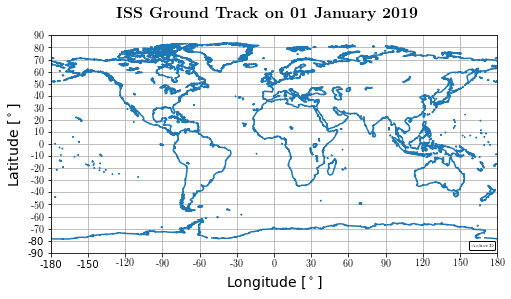

In [7]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------ #
## plot results     

# load in the coastline map. This is simple the image of the continents that we will superimpose the satellite paths onto.
# w, h is 
# 
coastline_data = np.loadtxt('/home/jovyan/work/Satellite_Ground_Track_Plotting_Python/Coastline.txt',skiprows=0)
w, h = plt.figaspect(0.5)
fig = plt.figure(figsize=(w,h))
ax = fig.gca()
plt.rc('text', usetex=True)
plt.rc('font', family='serif');
plt.rc('font',family='helvetica');
params = {'legend.fontsize': 8,
    'legend.handlelength': 2}
plt.rcParams.update(params)

groundtrack_title = satellite_obj.epoch.strftime('%d %B %Y')
fig.suptitle(r"\textbf{ISS Ground Track on %s}" %groundtrack_title,fontsize=16)
plt.plot(coastline_data[:,0],coastline_data[:,1]);
ax.set_xlabel(r'Longitude $[\mathrm{^\circ}]$',fontsize=14)
ax.set_ylabel(r'Latitude $[\mathrm{^\circ}]$',fontsize=14)
plt.xlim(-180,180);
plt.ylim(-90,90);
plt.yticks([-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90]);
plt.xticks([-180,-150,-120,-90,-60,-30,0,30,60,90,120,150,180]);

# for each timestep
 # plot the calculated lon and lat coordinates. 
for index in range(0,len(timevec)):
    plt.plot(math.degrees(lon[index]),math.degrees(lat[index]),'#377eb8',markersize=1);
    plt.plot(math.degrees(lon2[index]),math.degrees(lat2[index]),'#ff7f00',markersize=1);
    plt.plot(math.degrees(lon3[index]),math.degrees(lat3[index]),'#4daf4a',markersize=1);

ax.grid(True);
at = AnchoredText("AshivD",prop=dict(size=5), frameon=True,loc=4)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
fig.savefig('main_00_iss_ground_track.pdf',format='pdf',bbox_inches='tight',pad_inches=0.01,dpi=1200);

In [8]:
print('satellite number')
print (satellite_obj.satnum)
print('epochyr')
print (satellite_obj.epochyr)
print('epochdays')
print (satellite_obj.epochdays)
print('jdsatepoch')
print (satellite_obj.jdsatepoch)
print('epoch')
print(satellite_obj.epoch)
print('inclination')
print(math.degrees(satellite_obj.inclo))
print('RAAN')
print(math.degrees(satellite_obj.nodeo))
print('eccentricity')
print (satellite_obj.ecco)
print('argument of perigee')
print (math.degrees(satellite_obj.argpo))
print('mean anomaly')
print (math.degrees(satellite_obj.mo))

satellite number
1
epochyr
2019
epochdays
1.0
jdsatepoch
2458484.5
epoch
2019-01-01 00:00:00
inclination
90.0
RAAN
131.0922
eccentricity
0.0007174
argument of perigee
106.9148
mean anomaly
0.0
